In [9]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')  # change pyplots default style
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [10]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [11]:
import numpy as np
from scipy import signal
from scipy import fft
from scipy import ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d

from specsens import Stft

def spectrum_plot_3d(sig,
                     f_sample,
                     window='flattop',
                     nfft=1024,
                     clip=-60,
                     smooth=.5,
                     crop=None,
                     elev=30,
                     azim=60,
                     type='our',
                     title=None,
                     cmap='viridis',
                     save=False,
                     save_as='plot3d.png'):

    sft = Stft(n=nfft, window=window)
    f, t, ps = sft.spectogram(sig, f_sample, normalized=True, dB=True)

    if clip is not None:
        ps = clip2d(ps, clip, 0)
    if smooth is not None:
        ps = smooth2d(ps, sigma=smooth)
    if crop is not None:
        ps, f, t = crop2d(ps, f, t, crop)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    # ax.get_proj = lambda: np.dot(mpl3d.axes3d.Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))
    ax.plot_surface(f[:, None],
                    t[None, :],
                    ps,
                    cmap=cmap,
                    rstride=1,
                    cstride=1,
                    alpha=1,
                    antialiased=True)
    ax.view_init(elev=elev, azim=azim)

    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel(r'Frequency [Hz]')
    ax.set_ylabel(r'Time [s]')
    ax.set_zlabel(r'Power [dB]', rotation=90)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    plt.tight_layout()

    if save:
        plt.savefig(save_as, dpi=800)


def clip2d(ps, lim_min, lim_max):
    (x, y) = np.shape(ps)
    for i in range(x):
        for j in range(y):
            ps[i, j] = max(min(ps[i, j], lim_max), lim_min)
    return ps


def smooth2d(x, sigma):
    return ndimage.filters.gaussian_filter(x, [sigma, sigma], mode='mirror')


def crop2d(ps, f, t, n):
    ps = ps[n:-n, n:-n]
    f = f[n:-n]
    t = t[n:-n]
    return ps, f, t

In [17]:
# general settings for signal and noise
length = 0.5  # in s
noise_power = 10.0  # in dB
num_bands = 10

# create 'WidebandSignal' object
wbs = ss.WidebandSignal(t_sec=length, num_bands=num_bands, num_steps=10)

# signal power matrix (dimensions: num_bands x num_steps)
mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,   -3,    0,    3,    5,    7,   10, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100,    0,    3,    3,    0, -100,    0,    5,    0, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,   10,    5,    0,   -5,   -7,  -10,  -13, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100,    0,    0, -100, -100, -100],
                [-100,   10,   10,   10, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

# # plot the matrix
# plt.figure(figsize=(6, 3))
# plt.imshow(mat, aspect='auto')
# plt.xlabel(r'Time [Step]')
# plt.ylabel(r'Band')
# cbar = plt.colorbar()
# cbar.set_label(r'Power [dB]')
# plt.savefig('out/wideband_mat.pdf')

# generate actual signal from matrix
sig, sample_freq = wbs.signal(mat)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Created WidebandSignal with 1.0 MHz total bandwidth and 50000 samples per step.
Signal power: 8.87 dB
Noise power:  10.01 dB
SNR:          -1.14 dB
Num samples:  500000 


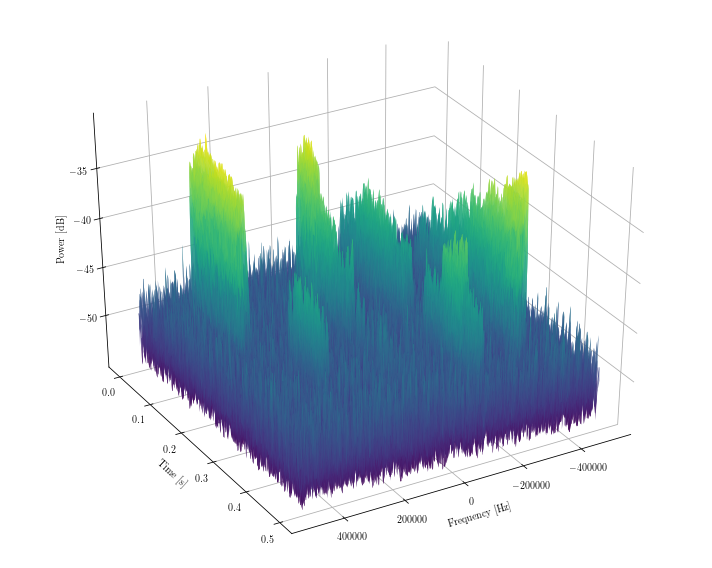

In [18]:
spectrum_plot_3d(sig=both,
                 f_sample=sample_freq,
                 window='flattop',
                 nfft=1024,
                 clip=-55,
                 smooth=.75,
                 elev=35,
                 azim=60,
                 save=True,
                 save_as='out/appe/wideband_3d.png')

In [20]:
# general settings for signal and noise
sample_freq = 1e5  # in Hz
length = 15.0  # in s
noise_power = 5.0  # in dB

# create 'DopplerSignal' object
ds = ss.DopplerSignal(
    t_sec=length,  # length of signal in seconds
    f_sample=sample_freq,  # sample frequency after decimation
    f_carrier=450e6,  # frequency of signal before down sapling to baseband
    steps=int(1e3))  # steps / resolution

# get frequency and power vectors that contain the doppler shift
t, freq, signal_power = ds.get(
    f_center=-1e4,  # center frequency at half way point in Hz
    power=0.,  # power at half way point in dB ('peak' power)
    distance=6000.0,  # distance in m
    velocity=8000.0)  # velocity in m/s

# create the signal (the 'very_silent' kind) using the doppler shift vectors
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.very_silent(f_center=freq, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: -5.33 dB
Noise power:  5.00 dB
SNR:          -10.33 dB
Num samples:  1500000


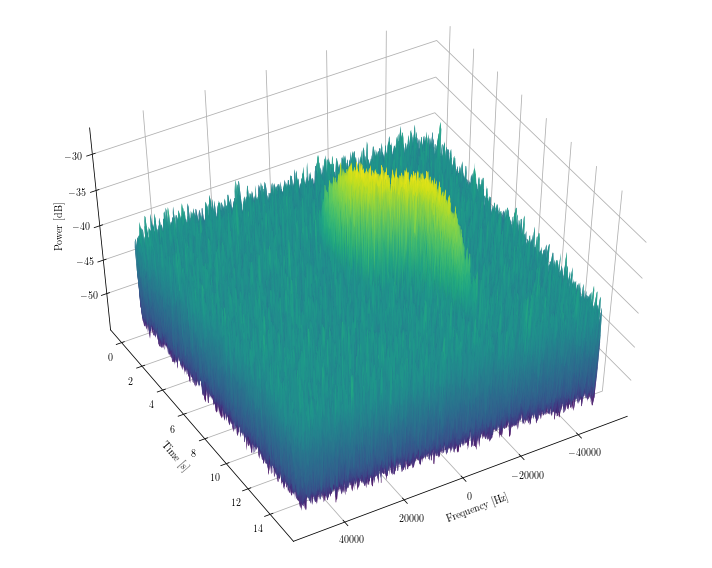

In [21]:
spectrum_plot_3d(sig=both,
                 f_sample=sample_freq,
                 window='flattop',
                 nfft=512,
                 clip=-55,
                 smooth=.5,
                 elev=50,
                 azim=60,
                 save=True,
                 save_as='out/appe/wideband_3d_doppler.png')